In [1]:
import os
from typing import Iterable

import joblib
import pandas as pd
import xgboost as xgb

from pathlib import Path
from loguru import logger
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


class PropensityModel:
    """Wrapper class for the Propensity ML model.

    Attributes:
        algo (str): Algorithm used to select the classifier.
        model (sklearn.BaseEstimator or xgb.XGBClassifier
            or CatBoostClassifier): Classifier.
    """

    def __init__(self, algo: str = "LogisticRegression", **kwargs: dict):
        """Initialise the classifier based on the chosen algorithm.

        Args:
            algo (str): Name of the algorithm used to select the classifier. Allowed
                options are ["LogisticRegression", "RandomForest", "XGBoost",
                "CatBoost"]. Defaults to "LogisticRegression".
            kwargs (dict, optional): Key-value pairs of model hyperparameters.

        Raises:
            ValueError: If one of the input parameters is of the wrong type.
        """

        try:
            assert algo in ["LogisticRegression", "RandomForest", "XGBoost", "CatBoost"]
        except AssertionError:
            msg = (
                "Parameter `algo` must be one of "
                '["LogisticRegression", "RandomForest", "XGBoost", "CatBoost"].'
            )
            logger.error(msg)
            raise ValueError(msg)

        self.algo = algo
        if self.algo == "LogisticRegression":
            self.model = LogisticRegression(**kwargs)
        elif self.algo == "RandomForest":
            self.model = RandomForestClassifier(**kwargs)
        elif self.algo == "XGBoost":
            self.model = xgb.XGBClassifier(importance_type="gain", **kwargs)
        elif self.algo == "CatBoost":
            self.model = CatBoostClassifier(loss_function="Logloss", **kwargs)

    def fit(self, X: pd.DataFrame, y: pd.Series, **kwargs: dict) -> None:
        self.model.fit(X, y, **kwargs)

    def predict(self, X: pd.DataFrame, **kwargs: dict) -> Iterable:
        return self.model.predict(X, **kwargs)

    def predict_proba(self, X: pd.DataFrame, **kwargs: dict) -> Iterable:
        return self.model.predict_proba(X, **kwargs)

    @classmethod
    def load_model(cls, file_name: str):
        """Load the model from a source file.

        Args:
            file_name (str): Path were model will be loaded.

        Returns:
            PropensityModel: an instance of this class.
        """
        model = joblib.load(file_name)
        result = cls(algo=model["algo"])
        result.model = model["model"]
        logger.info(f"Loaded model from {file_name}.")
        return result

    def save_model(self, file_name: str) -> None:
        """Save the model to a target file.

        Args:
            file_name (str): Path were model will be saved.
        """
        directory = Path(file_name).parent.absolute()
        os.makedirs(directory, exist_ok=True)
        joblib.dump({"algo": self.algo, "model": self.model}, file_name)
        logger.info(f"Saved model to {file_name}.")

    @property
    def feature_importances_(self, **kwargs: dict) -> Iterable:
        """Return the importance of the features used by the classifier.

        Args:
            kwargs (dict, optional): Key-value pairs of additional parameters for the
                underlying function called. Only used when `algo` = "CatBoost".
        """

        if self.algo == "LogisticRegression":
            return self.model.coef_[0]
        elif self.algo == "CatBoost":
            return self.model.get_feature_importance(**kwargs)
        else:
            return self.model.feature_importances_

In [16]:
from typing import Optional, Tuple, Union, List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from loguru import logger
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from IPython.display import display, HTML
from sklearn.metrics import (
    plot_roc_curve,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    RocCurveDisplay,
)


def _feature_importance(
    model: PropensityModel, train_df: Optional[pd.DataFrame] = None
) -> Tuple[Union[np.array, pd.Series], Union[np.array, pd.Series]]:
    """ """

    if model.algo == "LogisticRegression":
        if not isinstance(train_df, pd.DataFrame):
            msg = (
                "Parameter `train_df` must be a pandas DataFrame"
                + "when the algorithm is LogisticRegression."
            )
            logger.error(msg)
            raise ValueError(msg)
        train_df = train_df.loc[:, train_df.columns != "fttp_order"]
        importances = np.abs(np.std(train_df, 0) * model.feature_importances_)
    else:
        importances = model.feature_importances_
    indices = np.argsort(abs(importances))
    return importances, indices


def model_summary(
    model: PropensityModel,
    df: pd.DataFrame,
    dataset_name: str,
    max_features: Optional[int] = None,
    train_df: Optional[pd.DataFrame] = None,
) -> None:
    """ """

    def fmt(x, pos):
        return "{0:.0%}".format(x)

    X = df.loc[:, df.columns != "fttp_order"]
    y = df.loc[:, "fttp_order"]
    preds = model.predict(X)
    prob_preds = model.predict_proba(X)[:, 1]

    fig = plt.figure(figsize=(27, 8), constrained_layout=True)
    gs = GridSpec(figure=fig, nrows=4, ncols=6, hspace=0.05, wspace=0.1)
    ax1 = fig.add_subplot(
        gs[:, :-4]
    )  # Confusion Matrix spans all rows and first two columns
    ax2 = fig.add_subplot(
        gs[-2:, -4:-2]
    )  # ROC Curve spans last two rows and middle two columns
    ax3 = fig.add_subplot(
        gs[:-2, -4:-2]
    )  # Lift Curve spans first two rows and middle two columns
    ax4 = fig.add_subplot(
        gs[:, -2:]
    )  # Feature Importances spans all rows and last two columns

    # Plot Confusion Matrix
    cf_matrix = confusion_matrix(y, preds, normalize="true")
    group_names = ["TN", "FP", "FN", "TP"]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(
        cf_matrix,
        annot=labels,
        fmt="",
        cmap="viridis",
        vmin=0,
        vmax=1,
        cbar_kws={"extend": "both", "format": FuncFormatter(fmt), "extendrect": True},
        annot_kws={"size": 15},
        ax=ax1,
    )
    ax1.set_title("Confusion Matrix")

    # Plot ROC curve
    plot_roc_curve(model.model, X, y, ax=ax2)
    ax2.set_title("ROC Curve")

    # Plot Lift curve
    percentiles = [0] + list(np.percentile(prob_preds, np.arange(10, 110, 10)))

    step = 0.1
    # Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    # Create a real and predicted column for our new DataFrame and assign values
    aux_lift["real"] = y
    aux_lift["predicted"] = prob_preds
    aux_lift["predicted_bin"] = preds
    aux_lift["decile"] = np.floor(aux_lift["predicted"] * 10) / 10
    # Order the values for the predicted probability column:
    aux_lift.sort_values("predicted", ascending=False, inplace=True)

    # Create the values that will go into the X axis of our plot
    x_val = np.arange(step, 1 + step, step)
    # Calculate the ratio of ones in our data
    ratio_ones = aux_lift["real"].sum() / len(aux_lift)
    # Calculate the total number of predicted conversion
    total_pred_conversions = aux_lift["real"].sum()
    # Create empty vectors with the values that will go on the Y axis our our plot
    y_v = []
    cum_conv = []
    avg_conv = []

    # Calculate for each x value its correspondent y value
    for x in range(10):
        data_here = aux_lift[
            (aux_lift["predicted"] >= percentiles[x])
            & (aux_lift["predicted"] <= percentiles[x + 1])
        ]
        ratio_ones_here = data_here["real"].sum() / len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
        cum_conv.append(
            aux_lift[aux_lift["predicted"] >= percentiles[x]]["real"].sum()
            / total_pred_conversions
        )
        avg_conv.append(ratio_ones_here)

    # Plot the figure
    ax3_1 = ax3.twinx()
    ax3.bar(x_val, y_v[::-1], width=0.08)
    ax3_1.plot(x_val, cum_conv[::-1], "g-", linewidth=2, markersize=5)
    ax3.set_ylim([0, ax3.get_ylim()[1] + 0.2])

    rects = ax3.patches

    # Make some labels.
    labels = ["{:,.2%}".format(c) for c in avg_conv[::-1]]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax3.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.1,
            label,
            ha="center",
            va="bottom",
        )

    ax3.set_xticks(x_val, labels=[9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
    ax3.set_xlabel("Score")
    ax3.set_ylabel("Lift")
    ax3.set_title("Lift Curve")
    ax3_1.set_ylim([0, 1.05])
    ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax3_1.set_yticks(ticks)
    ax3_1.set_yticklabels(["{0:.0%}".format(t) for t in ticks])
    ax3_1.set_ylabel("Cumulated Conversion Rate")

    # Plot Feature Importances
    imps, idxs = _feature_importance(model, train_df)
    if not max_features:
        max_features = np.minimum(len(imps), 30)
    ax4.barh(range(max_features), imps[idxs[:max_features]], align="center")
    ax4.set_yticks(range(max_features), [X.columns[i] for i in idxs[-max_features:]])
    ax4.set_xlabel("Relative Importance (absolute values)")
    ax4.set_title("Feature Importances")

    fig.suptitle(
        f"Classification Metrics for {model.algo} model on {dataset_name} data"
    )

    plt.show()

In [7]:
model_path = './rf_model.joblib'
data_path = './valid_tra.csv'

In [8]:
model = PropensityModel.load_model(model_path)

2022-09-05 16:41:26.627 | INFO     | __main__:load_model:79 - Loaded model from ./rf_model.joblib.


In [5]:
valid_sample = pd.read_csv(data_path)

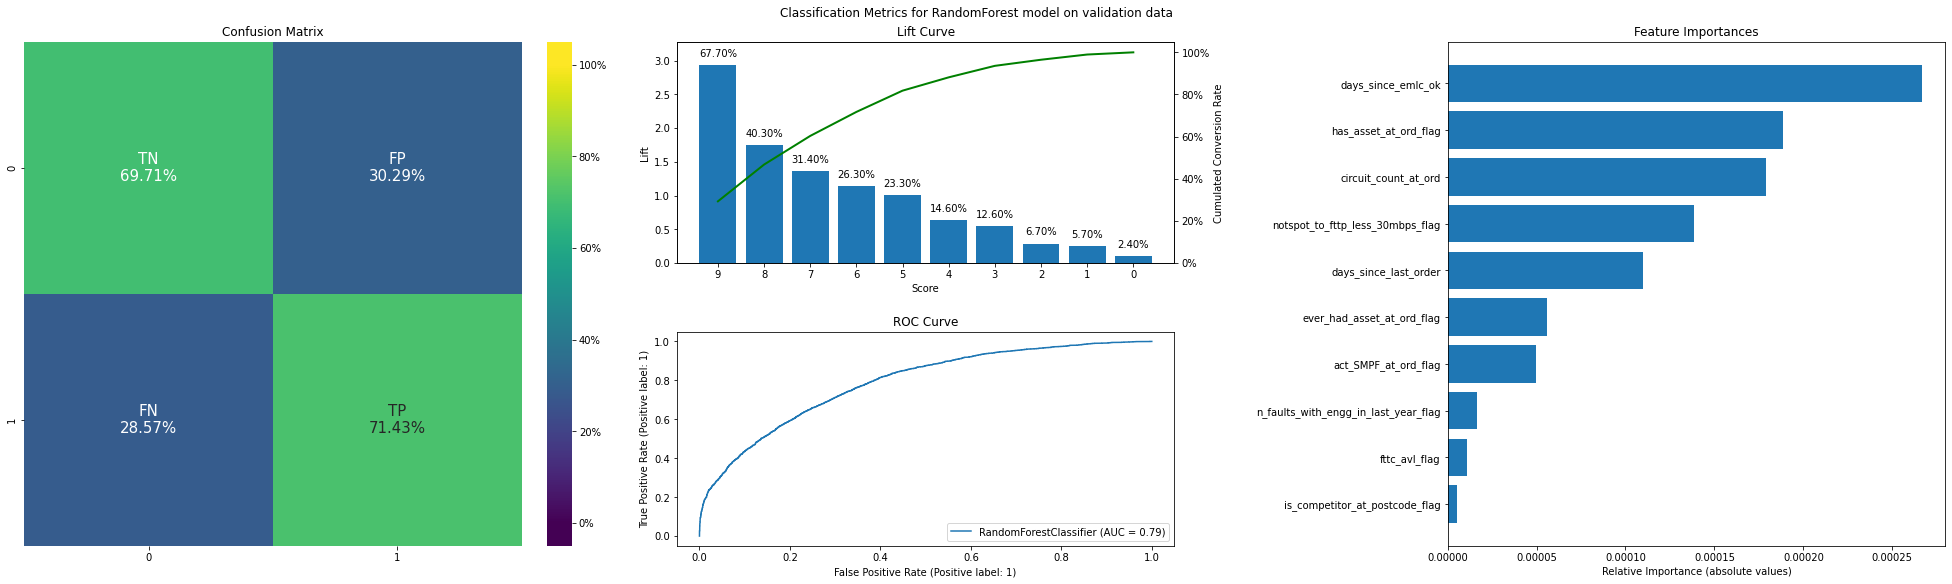

In [17]:
model_summary(model, valid_sample, "validation", max_features=10)

In [11]:
X = valid_sample.loc[:, valid_sample.columns != "fttp_order"]
y = valid_sample.loc[:, "fttp_order"]
preds = model.predict(X)
prob_preds = model.predict_proba(X)[:, 1]

In [19]:
df = pd.DataFrame(classification_report(y, preds, output_dict=True)).T
df.style.background_gradient(
    cmap='viridis',
    subset=pd.IndexSlice['0':'1', :'f1-score']
)

,precision,recall,f1-score,support
0,0.890384,0.697139,0.782000,7690.000000
1,0.414677,0.714286,0.524726,2310.000000
accuracy,0.701100,0.701100,0.701100,0.701100
macro avg,0.652530,0.705712,0.653363,10000.000000
weighted avg,0.780495,0.701100,0.722570,10000.000000
